In [3]:
import os
import torch
device = torch.device('cuda', 1)
# device = torch.device()
print(device)

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import random
import shutil
import time

cuda:1


In [94]:
"""
Image data should be organized like this:

KSSHP-dataset
|----ALL image tiles
|     |--train_val_data (90 % of ALL image tiles)
|     |      |----TUM
|     |      |----STR
|     |      |----OTHER
|     |      
|     |--train_data (2/3 of train_val_data)
|     |      |----TUM
|     |      |----STR
|     |      |----OTHER
|     |--val_data (1/3 of train_val_data)
|     |      |----TUM
|     |      |----STR
|     |      |----OTHER
|     |
|     |--test_data (10 % of ALL image tiles)
|     |      |----TUM
|     |      |----STR
|     |      |----OTHER

Kather-dataset
|----train_val_data_kather
|     |--TUM
|     |--STR
|     |--OTHER
|     
|----train_data_kather (2/3 of train_val_data_kather)
|     |--TUM
|     |--STR
|     |--OTHER
|
|----val_data_kather (1/3 of train_val_data_kather)
|     |--TUM
|     |--STR
|     |--OTHER

"""
# ksshp_root: root to ALL training data from private dataset (in this case KSSHP)
# kather_root: root to image tiles from Kather-datasest
# SETUP: which setup to use (1, 2 or 3):
#      - SETUP 1: pre-training with ImageNet and Kather-data before KSSHP-data
#      - SETUP 2: pre-training only with ImageNet before KSSHP-data
#      - SETUP 3: pre-training only with Kather-data without ImageNet



# normalize image tiles and transform them into pytorch-tensor
# returns data iterators for train_val, train, val and test images

def make_train_val_test_groups(ksshp_root, kather_root, SETUP):

    torch.manual_seed(1234)
    torch.cuda.manual_seed(1234)
    torch.backends.cudnn.deterministic = True
    batch = 32
    pretrained_size = 224
    means = [0.485, 0.456, 0.406]
    stds= [0.229, 0.224, 0.225]


    data_transforms = transforms.Compose([transforms.Resize(pretrained_size),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean = means, std = stds)])

    train_val_data = datasets.ImageFolder(root = os.path.join(ksshp_root, "tiles_224_balanced/"),
                                  transform = data_transforms)
    
    train_data = datasets.ImageFolder(root = os.path.join(ksshp_root, "tiles_224_TRAIN/"),
                                  transform = data_transforms)
    
    val_data = datasets.ImageFolder(root = os.path.join(ksshp_root, "tiles_224_VAL/"),
                                  transform = data_transforms)
    
    test_data = datasets.ImageFolder(root = os.path.join(ksshp_root, "tiles_224_test/"),
                                  transform = data_transforms)
    
    if (SETUP == 3):
        
        means = torch.zeros(3)
        stds = torch.zeros(3)

        for img, label in train_data:
            means += torch.mean(img, dim = (1,2))
            stds += torch.std(img, dim = (1,2))

        means /= len(train_data)
        stds /= len(train_data)
        print(f'Means: {means}')
        print(f'Stds: {stds}')

        train_val_data = datasets.ImageFolder(root = os.path.join(ksshp_root, "ALL/train_val_data/"),
                                      transform = data_transforms)

        train_data = datasets.ImageFolder(root = os.path.join(ksshp_root, "ALL/train_data/"),
                                      transform = data_transforms)

        val_data = datasets.ImageFolder(root = os.path.join(ksshp_root, "ALL/val_data/"),
                                      transform = data_transforms)

        test_data = datasets.ImageFolder(root = os.path.join(ksshp_root, "ALL/test_data/"),
                                      transform = data_transforms)
    

    print(f'Training and validation images: {len(train_val_data)}')
    print(f'Training images: {len(train_data)}')
    print(f'Validation images: {len(val_data)}')
    print(f'Test images: {len(test_data)}')
    
    return train_val_data, train_data, val_data, test_data

def make_iterator(dataset, batch):
    
    iterator = data.DataLoader(dataset, shuffle = True, batch_size = batch)

    return iterator
    

Training and validation images: 24399
Training images: 16353
Validation images: 8046
Test images: 2700
[   0    1    2 ... 8043 8044 8045]
0


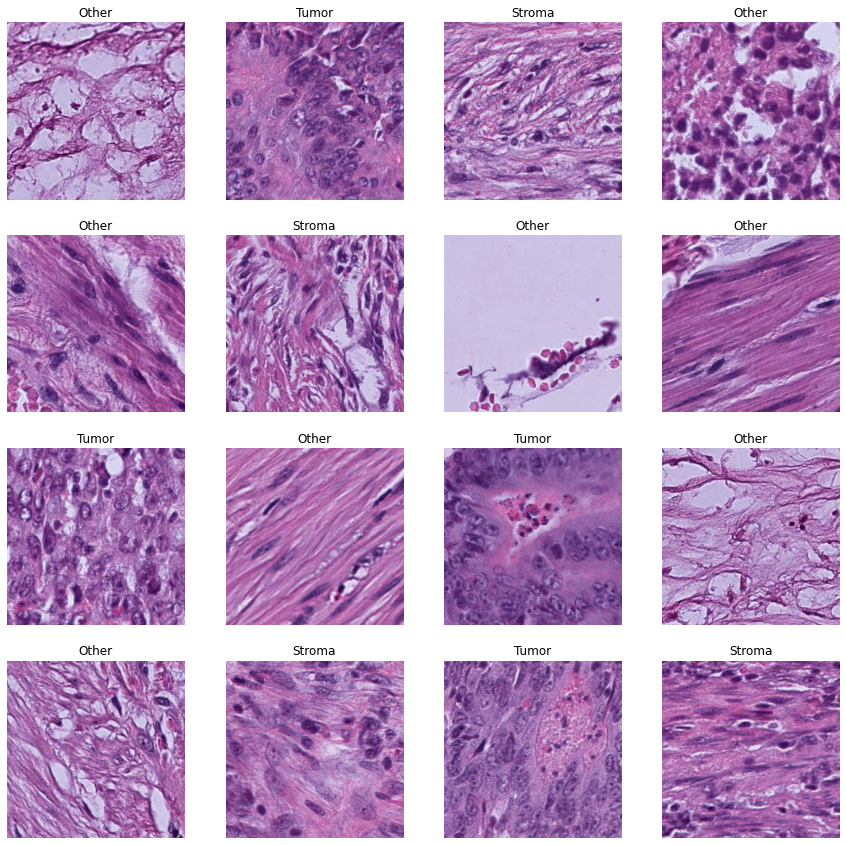

In [95]:
train_val_data, train_data, val_data, test_data = make_train_val_test_groups("/n/archive00/labs/IT/JYU_AIHUB/HE20x/", "_", 1)
train_val_iterator = make_iterator(train_val_data, 32)
train_iterator = make_iterator(train_data, 32)
val_iterator = make_iterator(val_data, 32)
test_iterator = make_iterator(test_data, 32)
    
plot_image_examples(val_data)
print(val_dataset[0][1])

In [80]:
def plot_image_examples(dataset):
    
    idxs = np.arange(0,len(dataset),1, dtype='int')
    idxs = list(idxs)
    sampleidxs = random.choices(idxs, k=20)
    classes = dataset.classes
    images, labels = zip(*[(img, label) for img, label in [dataset[sampleidxs[i]] for i in range(len(sampleidxs))]])

    rows = int(np.sqrt(len(sampleidxs)))
    cols = int(np.sqrt(len(sampleidxs)))

    fig = plt.figure(figsize = (15, 15))

    for j in range(rows*cols):

        ax = fig.add_subplot(rows, cols, j+1)
        image = images[j]
        image_min = image.min()
        image_max = image.max()
        image.clamp_(min = image_min, max = image_max)
        image.add_(-image_min).div_(image_max - image_min + 1e-5)
        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[j]]
        ax.set_title(label)
        ax.axis('off')

In [99]:
def calc_acc(y_pred, y):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(1, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        acc = correct / batch_size
    return acc

In [128]:
def train(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        acc = calc_acc(y_pred, y)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    epoch_loss /= len(iterator)
    epoch_acc /= len(iterator)
        
    return epoch_loss, epoch_acc

In [129]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            acc = calc_acc(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    epoch_loss /= len(iterator)
    epoch_acc /= len(iterator)
        
    return epoch_loss, epoch_acc

In [86]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [134]:
# this is an example using pretrained alexnet

def prepare_model(number_of_classes):
    
    pretrained_model = models.alexnet(pretrained = True)  
    in_feat = pretrained_model.classifier[6].in_features 
    out_dim = number_of_classes
    fc = nn.Linear(in_feat, out_dim)

    pretrained_model.fc = fc
    model = pretrained_model

    return model

def cross_validate(epochs, train_data, train_iterator):
    
    best_loss = float('inf')
    best_acc = float('inf')
    k_folds = 5
    steps = len(train_iterator)
    total_steps = epochs * steps * k_folds
    training_times = np.zeros((epochs, 2))
    
    kfold = KFold(n_splits=k_folds, shuffle=True)

    for fold, (train_ids, val_ids) in enumerate(kfold.split(train_data)):

        model = prepare_model(train_data.classes)
        
        LR = [1e-3, 2e-3, 3e-3, 4e-3, 5e-3]

        # alexnet
        params = [
                  {'params': model.features[0].parameters(), 'lr': LR[fold] / 10},
                  {'params': model.features[3].parameters(), 'lr': LR[fold] / 8},
                  {'params': model.features[6].parameters(), 'lr': LR[fold] / 6},
                  {'params': model.features[8].parameters(), 'lr': LR[fold] / 4},
                  {'params': model.features[10].parameters(), 'lr': LR[fold] / 2},
                  {'params': model.fc.parameters()}
                 ]

        model.load_state_dict(model_.state_dict())
        # if you already have a pre-trained model using some other dataset, you can load it instead:
    #     model.load_state_dict(torch.load('SETUP_1_alexnet_PUBLIC_done.pt'))

        if(fold==0):    
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(params, lr = LR[fold])
            op = "Adam"

        if(fold==1):
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.SGD(params, lr = LR[fold])
            op = "SGD"

        if(fold==2):
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.SGD(params, lr = LR[fold])
            op = "SGD"

        if(fold==3):
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(params, lr = LR[fold])
            op = "Adam"

        if(fold==4):
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.SGD(params, lr = LR[fold])
            op = "SGD"

        model = model.to(device)
        criterion = criterion.to(device)

        max_lrs = [p['lr'] for p in optimizer.param_groups]
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr = max_lrs, total_steps = total_steps)


        print("Alexnet")
        print(f'FOLD {fold}')
        print('--------------------------------')

        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

        trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, sampler=train_subsampler)
        val_loader = torch.utils.data.DataLoader(train_data,batch_size=32, sampler=val_subsampler)

        for epoch in range(epochs):

                start_time = time.monotonic()

                train_loss, train_acc = train(model, trainloader, optimizer, criterion, scheduler, device)
                val_loss, val_acc = evaluate(model, val_loader, criterion, device)

                end_time = time.monotonic()

                epoch_mins, epoch_secs = epoch_time(start_time, end_time)

                training_times[epoch-1,0] = epoch_mins
                training_times[epoch-1,1] = epoch_secs

                print("FOLD "+ str(fold)+": ")
                print("-------------------------")
                print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
                print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:6.2f}% | ')
                print(f'\tValidation Loss: {val_loss:.3f} | Validation Acc: {train_acc*100:6.2f}% | ')

                if val_loss < best_loss:
                        best_loss = val_loss
                        best_acc = val_acc
                        from_fold = fold
                        with_op = op
                        learning_rate = LR[fold]

        print(f'\n Fold {fold}: Best validation loss: {best_loss:.3f} | Best validation acc: {best_acc*100:6.2f}% | ')

        averages = np.mean(training_times, axis = 0)
        average_mins = averages[0]
        average_secs = averages[1]

    print("Best params in fold"+str(from_fold)+" with learning rate "+str(learning_rate)+", optimizer "+with_op)
    
    return op, learning_rate

Alexnet
-------------------------
Epoch: 01 | Epoch Time: 0m 31s
	Train Loss: 2.374 | Train Acc:  49.00% | 

 <Val Loss: 0.627 | Val Acc:  77.32% | 


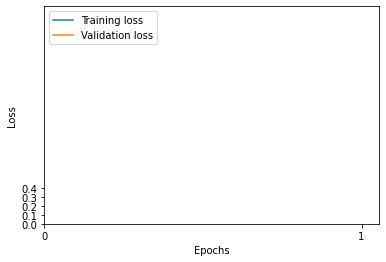

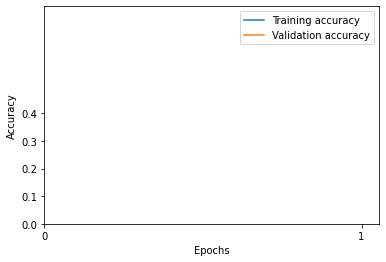

Alexnet
-------------------------
Epoch: 02 | Epoch Time: 3m 8s
	Train Loss: 0.709 | Train Acc:  75.22% | 

 <Val Loss: 0.468 | Val Acc:  82.90% | 


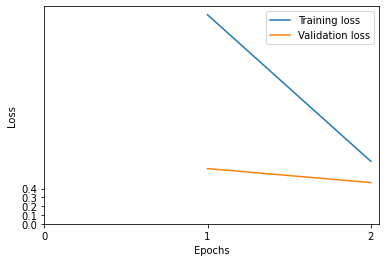

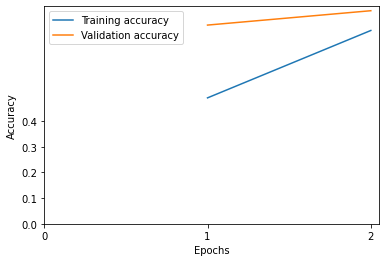

Alexnet
-------------------------
Epoch: 03 | Epoch Time: 2m 7s
	Train Loss: 0.536 | Train Acc:  81.15% | 

 <Val Loss: 0.355 | Val Acc:  86.74% | 


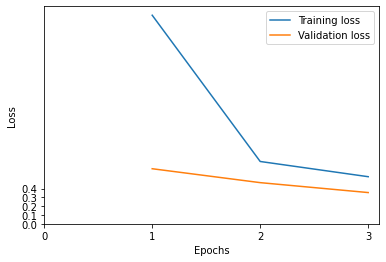

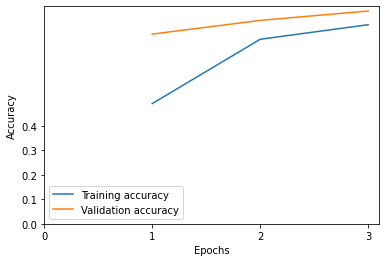

Alexnet
-------------------------
Epoch: 04 | Epoch Time: 1m 5s
	Train Loss: 0.457 | Train Acc:  83.90% | 

 <Val Loss: 0.474 | Val Acc:  83.44% | 


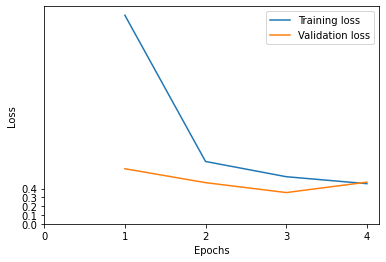

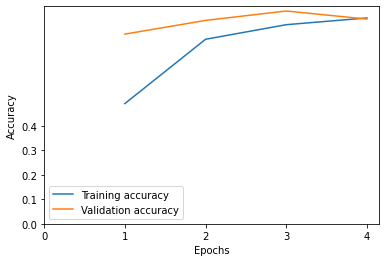

Alexnet
-------------------------
Epoch: 05 | Epoch Time: 2m 58s
	Train Loss: 0.461 | Train Acc:  83.76% | 

 <Val Loss: 0.349 | Val Acc:  87.32% | 


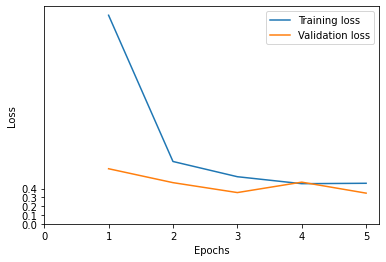

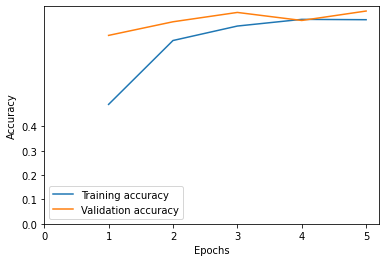

Alexnet
-------------------------
Epoch: 06 | Epoch Time: 0m 47s
	Train Loss: 0.352 | Train Acc:  87.84% | 

 <Val Loss: 0.262 | Val Acc:  90.60% | 


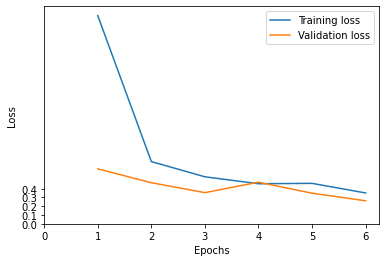

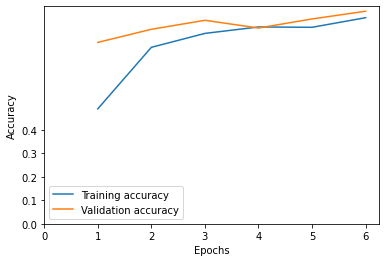

Alexnet
-------------------------
Epoch: 07 | Epoch Time: 2m 37s
	Train Loss: 0.302 | Train Acc:  89.34% | 

 <Val Loss: 0.365 | Val Acc:  86.58% | 


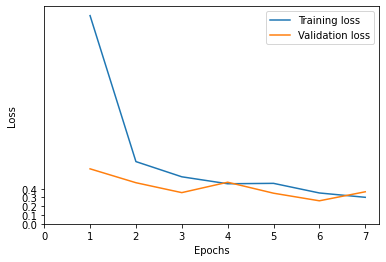

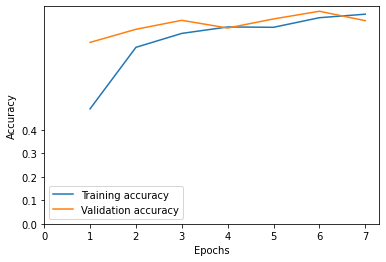

Alexnet
-------------------------
Epoch: 08 | Epoch Time: 1m 30s
	Train Loss: 0.277 | Train Acc:  90.39% | 

 <Val Loss: 0.239 | Val Acc:  91.10% | 


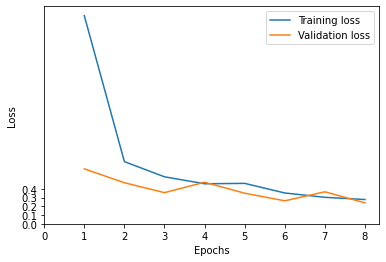

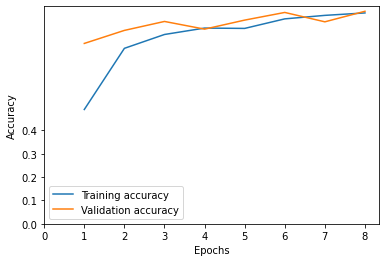

Alexnet
-------------------------
Epoch: 09 | Epoch Time: 0m 46s
	Train Loss: 0.250 | Train Acc:  91.33% | 

 <Val Loss: 0.205 | Val Acc:  92.66% | 


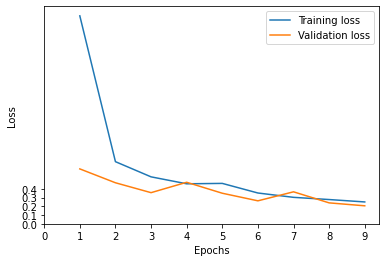

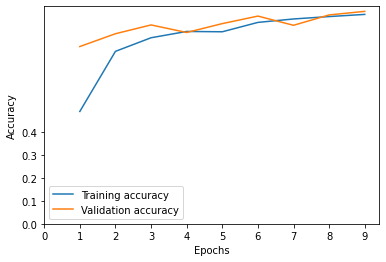

Alexnet
-------------------------
Epoch: 10 | Epoch Time: 0m 27s
	Train Loss: 0.224 | Train Acc:  92.25% | 

 <Val Loss: 0.276 | Val Acc:  90.47% | 


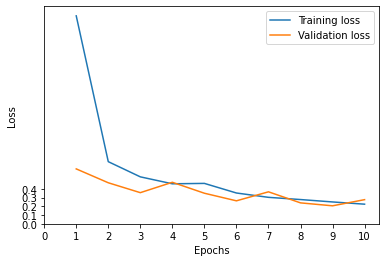

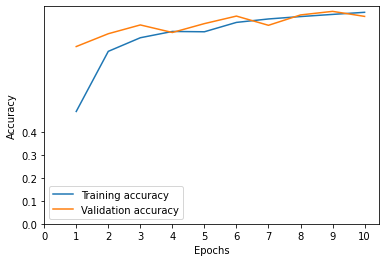

KeyboardInterrupt: 

In [110]:
# optimizer, learning_rate = cross_validate(10, test_data, test_iterator)
train_and_plot(val_iterator, test_iterator, optimizer, 40, learning_rate)

In [112]:
# to choose the best possible amount of epochs for the final model, train the model with
# chosen parameters (above) at least for 40 epochs or so and plot the results. 
# Use train- and validation -datasets.

def train_and_plot(train_iterator, val_iterator, optimizer, epochs, found_lr):
    
    best_loss = float('inf')
    best_acc = float('inf')

    losses_train = []
    losses_val = []
    acc_train = []
    acc_val = [] 

    steps = len(train_iterator)
    total_steps = epochs * steps * k_folds

    training_times = np.zeros((epochs, 2))

    model = prepare_model(train_data.classes)

    params = [
                  {'params': model.features[0].parameters(), 'lr': found_lr / 10},
                  {'params': model.features[3].parameters(), 'lr': found_lr / 8},
                  {'params': model.features[6].parameters(), 'lr': found_lr / 6},
                  {'params': model.features[8].parameters(), 'lr': found_lr / 4},
                  {'params': model.features[10].parameters(), 'lr': found_lr / 2},
                  {'params': model.fc.parameters()}
                 ]

    if (optimizer == "Adam"):
        optimizer = optim.Adam(params, lr = found_lr)
        
    if (optimizer == "SGD"):
        optimizer = optim.SGD(params, lr = found_lr)
        
    model.load_state_dict(model_.state_dict())
    # model.load_state_dict(torch.load('SETUP_1_alexnet_PUBLIC_done.pt'))

    criterion = nn.CrossEntropyLoss()
    model = model.to(device)
    criterion = criterion.to(device)

    max_lrs = [p['lr'] for p in optimizer.param_groups]
    scheduler = lr_scheduler.OneCycleLR(optimizer,max_lr = max_lrs, total_steps = total_steps)

    for epoch in range(epochs):

        start_time = time.monotonic()

        train_loss, train_acc = train(model, train_iterator, optimizer, criterion, scheduler, device)
        val_loss, val_acc = evaluate(model, val_iterator, criterion, device)

        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        training_times[epoch-1,0] = epoch_mins
        training_times[epoch-1,1] = epoch_secs

        print("Alexnet")
        print("-------------------------")
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain loss: {train_loss:.3f} | Train accuracy: {train_acc*100:6.2f}% | ')
        print(f'\n Validation loss: {val_loss:.3f} | Validation accuracy: {val_acc*100:6.2f}% | ')

        losses_train.append(train_loss)
        losses_val.append(val_loss)
        acc_train.append(train_acc)
        acc_val.append(val_acc)

        epochs1 = range(1, len(losses_train)+1)
        epochs2 = range(1, len(acc_train)+1)

        plt.plot(epochs1, losses_train, label='Training loss')
        plt.plot(epochs1, losses_val, label='Validation loss')
        plt.xticks(np.arange(0, len(epochs2)+1, 1))
        plt.yticks(np.arange(0, 1, 0.1))

        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.show()

        plt.plot(epochs2, acc_train, label='Training accuracy')
        plt.plot(epochs2, acc_val, label='Validation accuracy')
        plt.xticks(np.arange(0, len(epochs2)+1, 1))
        plt.yticks(np.arange(0, 1, 0.1))

        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()

    averages = np.mean(training_times, axis = 0)
    average_mins = averages[0]
    average_secs = averages[1]
    
    results = [losses_train, losses_val, acc_train, acc_val]
    
    for i in range(len(results)):
        np.save("./", results[i])
        
    print("Average training time/epoch: " + str(average_mins) + " m, " + str(average_secs) + " s.")

In [133]:
# choose the amount of epochs based on the plots above, then train the final model
# with all training data (train_val_data)
train_final(train_val_iterator, 5, optimizer, learning_rate, "./")

KeyboardInterrupt: 

In [135]:
def train_final(train_val_iterator, epochs, optimizer, found_lr, save_root):
    
    steps = len(train_val_iterator)
    total_steps = epochs * steps

    training_times = np.zeros((epochs, 2))

    model = prepare_model(3)

    params = [
                  {'params': model.features[0].parameters(), 'lr': found_lr / 10},
                  {'params': model.features[3].parameters(), 'lr': found_lr / 8},
                  {'params': model.features[6].parameters(), 'lr': found_lr / 6},
                  {'params': model.features[8].parameters(), 'lr': found_lr / 4},
                  {'params': model.features[10].parameters(), 'lr': found_lr / 2},
                  {'params': model.fc.parameters()}
                 ]

    if (optimizer == "Adam"):
        optimizer = optim.Adam(params, lr = found_lr)
        
    if (optimizer == "SGD"):
        optimizer = optim.SGD(params, lr = found_lr)

    model.load_state_dict(model.state_dict())
    
    # model.load_state_dict(torch.load('SETUP_1_alexnet_PUBLIC_done.pt'))

    criterion = nn.CrossEntropyLoss()
    model = model.to(device)
    criterion = criterion.to(device)

    max_lrs = [p['lr'] for p in optimizer.param_groups]
    scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr = max_lrs, total_steps = total_steps)

    for epoch in range(epochs):

        start_time = time.monotonic()

        train_loss, train_acc = train(model, train_iterator, optimizer, criterion, scheduler, device)

        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        training_times[epoch-1,0] = epoch_mins
        training_times[epoch-1,1] = epoch_secs

        print("Alexnet FINAL model")
        print("-------------------------")
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ')
        
    averages = np.mean(training_times, axis = 0)
    average_mins = averages[0]
    average_secs = averages[1]

    torch.save(model.state_dict(), os.path.join(save_root, "alexnet_model.pt"))
    print(f"Model training complete, saved to: {save_root}")
    print(f"Average training time/epoch: {average_mins} m, {average_secs} s.")

Test loss: 0.116 | Test accuracy:  96.89% | 


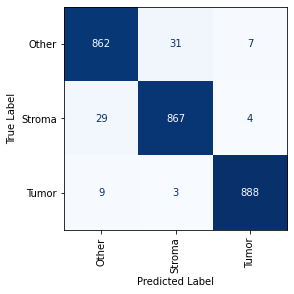

In [127]:
def test_model_plot_results(root_to_model, test_iterator, classes):
    
    model = prepare_model(len(classes))
    criterion = nn.CrossEntropyLoss()
    
    model.load_state_dict(torch.load(root_to_model))
    model = model.to(device)
    criterion.to(device)
    
    test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
    print(f'Test loss: {test_loss:.3f} | Test accuracy: {test_acc*100:6.2f}% | ')
    
    images, labels, probs = get_predictions(model, test_iterator)
    pred_labels = torch.argmax(probs, 1)
    plot_confusion_matrix(labels, pred_labels, classes)

test_model_plot_results("./SETUP_1_alexnet_FINAL.pt", test_iterator, test_data.classes)

In [136]:
def get_predictions(model, iterator):

    model.eval()
    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)
            y_pred = model(x)
            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (5, 5));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(cmap = 'Blues', ax = ax)
    fig.delaxes(fig.axes[1]) #delete colorbar
    plt.xticks(rotation = 90)
    plt.xlabel('Predicted Label', fontsize = 10)
    plt.ylabel('True Label', fontsize = 10)